In [42]:
# import numpy as np
# import matplotlib.pyplot as plt
# import torch
# from torch.utils.data import Dataset, DataLoader

# import numpy as np
# import torch
# from torch.utils.data import Dataset

# # -------------------------------
# # 1️⃣ 读取谱线列表文件
# # -------------------------------
# def read_line_list(filepath):
#     lines, freqs = [], []
#     with open(filepath, 'r') as f:
#         for line in f:
#             if line.strip() == '':
#                 continue
#             parts = line.split()
#             if len(parts) < 2:
#                 continue
#             lines.append(parts[0])
#             freqs.append(float(parts[1]))
#     return lines, np.array(freqs)


# class SpectrumByLineDataset(Dataset):
#     def __init__(self, spectrum_file, line_file, window=0.03, target_len=256,
#                  normalize=True, velocity=None):
#         self.line_names, self.line_rest = read_line_list(line_file)
#         c = 299792458  # m/s

#         # --- 读取主光谱，跳过第一行 ---
#         data = np.loadtxt(spectrum_file, skiprows=1)
#         freq_obs, flux = data[:, 0], data[:, 1]

#         # --- 速度校正 ---
#         if velocity is not None:
#             v = velocity * 1e3  # km/s → m/s
#             freq = freq_obs * (1 + v / c)
#             print(f"[INFO] Applied velocity correction: v = {velocity:.3f} km/s")
#         else:
#             freq = freq_obs

#         self.samples, self.names = [], []
#         self.normalize = normalize

#         for name, f_rest in zip(self.line_names, self.line_rest):
#             mask = (freq > f_rest - window) & (freq < f_rest + window)
#             if np.sum(mask) < 8:
#                 continue

#             f_sub = freq[mask]
#             flux_sub = flux[mask]

#             # 插值
#             f_new = np.linspace(f_sub.min(), f_sub.max(), target_len)
#             flux_new = np.interp(f_new, f_sub, flux_sub)

#             # 可选归一化
#             if normalize:
#                 flux_new = (flux_new - np.mean(flux_new)) / (np.std(flux_new) + 1e-6)

#             # 保存子光谱
#             self.samples.append(torch.tensor(flux_new, dtype=torch.float32).unsqueeze(0))
#             self.names.append(name)

#     def __len__(self):
#         return len(self.samples)

#     def __getitem__(self, idx):
#         return self.samples[idx], self.names[idx]



# # -------------------------------
# # 3️⃣ 使用示例
# # -------------------------------
# spectrum_file = "C:\\Users\\zyx\\Desktop\\Spectral with Machine Learning\\data\\spw1\\spectrum.Lh07.spw0.commonbeam.1arcsec.dat"
# line_file = "C:\\Users\\zyx\\Desktop\\Spectral with Machine Learning\\data\\linelist_lsb.dat"  # 包含 line name + freq
# dataset = SpectrumByLineDataset(
#     spectrum_file, line_file, velocity=239.5157166
# )


# print(f"共找到 {len(dataset)} 条谱线样本")
# for i in range(len(dataset)):
#     x, name = dataset[i]
#     print(f"{i+1}. {name}  子光谱长度: {x.shape[-1]}")

# # 可视化前几条谱线
# #plt.figure(figsize=(8, 6))
# for i in range(len(dataset)):
#     x, name = dataset[i]
#     plt.plot(x.squeeze().numpy(), label=name)
#     plt.legend()
#     plt.title("Extracted Line Spectra")
#     plt.xlabel("Resampled index")
#     plt.ylabel("Normalized Flux")
#     plt.tight_layout()
#     plt.show()


In [56]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import glob
import os

# -------------------------------
# 1️⃣ 读取谱线列表文件
# -------------------------------
def read_line_list(filepath):
    lines, freqs = [], []
    with open(filepath, 'r') as f:
        for line in f:
            if line.strip() == '':
                continue
            parts = line.split()
            if len(parts) < 2:
                continue
            lines.append(parts[0])
            freqs.append(float(parts[1]))
    return lines, np.array(freqs)

# -------------------------------
# 2️⃣ 多文件光谱数据集类
# -------------------------------
class MultiSourceSpectrumDataset(Dataset):
    def __init__(self, data_dir, line_file, window=0.03, target_len=128,
                 normalize=True, velocity_dict=None):
        """
        初始化多源光谱数据集
        
        参数:
        - data_dir: 包含所有光谱文件的目录
        - line_file: 谱线列表文件路径
        - window: 提取窗口大小
        - target_len: 目标子光谱长度
        - normalize: 是否归一化
        - velocity_dict: 字典，键为源名称，值为速度修正值 (km/s)
        """
        self.line_names, self.line_rest = read_line_list(line_file)
        self.c = 299792458  # m/s
        self.window = window
        self.target_len = target_len
        self.normalize = normalize
        
        # 如果没有提供速度字典，创建空字典
        if velocity_dict is None:
            velocity_dict = {}
        
        # 存储所有样本和对应的信息
        self.samples = []        # 光谱数据
        self.full_names = []     # 完整标识符，格式: "源-频率窗口-谱线名称"
        self.source_info = []    # 源信息，格式: (源名称, 频率窗口, 谱线名称)
        self.scales=[]           # 初始化缩放因子列表
        
        # 查找所有光谱文件
        # 假设文件命名格式: "spectrum.源名称.频率窗口.commonbeam.1arcsec.dat"
        pattern = os.path.join(data_dir, "spectrum.*.spw*.commonbeam.1arcsec.dat")
        spectrum_files = glob.glob(pattern)
        
        if not spectrum_files:
            print(f"警告: 在目录 {data_dir} 中没有找到匹配的光谱文件")
            return
        
        print(f"找到 {len(spectrum_files)} 个光谱文件")
        
        # 处理每个光谱文件
        for spectrum_file in spectrum_files:
            # 从文件名中提取源名称和频率窗口
            filename = os.path.basename(spectrum_file)
            parts = filename.split('.')
            if len(parts) < 3:
                print(f"跳过无法解析的文件: {filename}")
                continue
                
            source_name = parts[1]  # 例如 "Lh07"
            spw = parts[2]          # 例如 "spw0"
            
            print(f"处理文件: {filename}, 源: {source_name}, 频率窗口: {spw}")
            
            # 获取该源的速度修正值
            velocity = velocity_dict.get(source_name, None)
            
            # 处理单个光谱文件
            self._process_single_file(spectrum_file, source_name, spw, velocity)
        
        print(f"总共提取了 {len(self.samples)} 个谱线样本")
    
    def _process_single_file(self, spectrum_file, source_name, spw, velocity=None):
        """处理单个光谱文件"""
        try:
            # 读取主光谱，跳过第一行
            data = np.loadtxt(spectrum_file, skiprows=1)
            freq_obs, flux = data[:, 0], data[:, 1]
            
            # 速度校正
            if velocity is not None:
                v = velocity * 1e3  # km/s → m/s
                freq = freq_obs * (1 + v / self.c)
                print(f"  [INFO] 应用速度修正: v = {velocity:.3f} km/s")
            else:
                freq = freq_obs
            
            # 对每条谱线提取子光谱
            for line_name, f_rest in zip(self.line_names, self.line_rest):
                mask = (freq > f_rest - self.window) & (freq < f_rest + self.window)
                if np.sum(mask) < 8:
                    continue  # 跳过数据点太少的谱线
                
                f_sub = freq[mask]
                flux_sub = flux[mask]
                
                # 插值到目标长度
                f_new = np.linspace(f_sub.min(), f_sub.max(), self.target_len)
                flux_new = np.interp(f_new, f_sub, flux_sub)
                
                # 归一化 (可选)
                if self.normalize:
                    flux_norm = (flux_new - np.mean(flux_new)) / (np.std(flux_new) + 1e-6)
#                     scale = max(np.max(np.abs(flux_new)), 1e-6)
#                     flux_norm = flux_new / scale
                else:
                    scale=1.0
                    flux_norm=flux_new

                
                # 创建完整标识符
                full_name = f"{source_name}-{spw}-{line_name}"
                
                # 保存样本和相关信息
                self.samples.append(torch.tensor(flux_norm, dtype=torch.float32).unsqueeze(0))
                self.full_names.append(full_name)
                self.source_info.append((source_name, spw, line_name))
                #self.scales.append(scale)  # 保存了缩放因子

                
        except Exception as e:
            print(f"处理文件 {spectrum_file} 时出错: {e}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx], self.full_names[idx] #, self.scales[idx]
    
    def get_source_info(self, idx):
        """获取指定索引样本的源信息"""
        return self.source_info[idx]
    
    def get_samples_by_source(self, source_name):
        """获取特定源的所有样本索引"""
        return [i for i, info in enumerate(self.source_info) if info[0] == source_name]
    
    def get_samples_by_spw(self, spw):
        """获取特定频率窗口的所有样本索引"""
        return [i for i, info in enumerate(self.source_info) if info[1] == spw]
    
    def get_samples_by_line(self, line_name):
        """获取特定谱线的所有样本索引"""
        return [i for i, info in enumerate(self.source_info) if info[2] == line_name]

    
def collate_fn(batch):
    """处理批次数据，包括缩放因子"""
    xs = torch.stack([b[0] for b in batch])  # 光谱数据
    names = [b[1] for b in batch]            # 名称列表
    
#     scales_list = [b[2] for b in batch]
#     scales = torch.tensor(scales_list, dtype=torch.float32)
#     scales = scales.view(-1, 1, 1)  # 重塑为 [batch_size, 1, 1]
    
    return xs, names #, scales
    
    
# -------------------------------
# 3️⃣ 使用示例
# -------------------------------
if __name__ == "__main__":
    # 数据目录和谱线列表
    data_dir = "C:\\Users\\zyx\\Desktop\\Spectral with Machine Learning\\data\\manysource"
    line_file = "C:\\Users\\zyx\\Desktop\\Spectral with Machine Learning\\data\\linelist_lsb.dat"
    
    # 定义各源的速度修正值 (km/s)
    velocity_dict = {
        "Lh07": 239.5157166,
        "Lh09": 235.751358,  
        "Lh10": 251.2273865,  
        # 添加更多源和对应的速度...
    }
    
    # 创建多源数据集
    dataset = MultiSourceSpectrumDataset(
        data_dir=data_dir,
        line_file=line_file,
        velocity_dict=velocity_dict,
        target_len=256,
        normalize=True
    )

找到 15 个光谱文件
处理文件: spectrum.Lh07.spw0.commonbeam.1arcsec.dat, 源: Lh07, 频率窗口: spw0
  [INFO] 应用速度修正: v = 239.516 km/s
处理文件: spectrum.Lh07.spw1.commonbeam.1arcsec.dat, 源: Lh07, 频率窗口: spw1
  [INFO] 应用速度修正: v = 239.516 km/s
处理文件: spectrum.Lh07.spw2.commonbeam.1arcsec.dat, 源: Lh07, 频率窗口: spw2
  [INFO] 应用速度修正: v = 239.516 km/s
处理文件: spectrum.Lh07.spw3.commonbeam.1arcsec.dat, 源: Lh07, 频率窗口: spw3
  [INFO] 应用速度修正: v = 239.516 km/s
处理文件: spectrum.Lh07.spw4.commonbeam.1arcsec.dat, 源: Lh07, 频率窗口: spw4
  [INFO] 应用速度修正: v = 239.516 km/s
处理文件: spectrum.Lh09.spw0.commonbeam.1arcsec.dat, 源: Lh09, 频率窗口: spw0
  [INFO] 应用速度修正: v = 235.751 km/s
处理文件: spectrum.Lh09.spw1.commonbeam.1arcsec.dat, 源: Lh09, 频率窗口: spw1
  [INFO] 应用速度修正: v = 235.751 km/s
处理文件: spectrum.Lh09.spw2.commonbeam.1arcsec.dat, 源: Lh09, 频率窗口: spw2
  [INFO] 应用速度修正: v = 235.751 km/s
处理文件: spectrum.Lh09.spw3.commonbeam.1arcsec.dat, 源: Lh09, 频率窗口: spw3
  [INFO] 应用速度修正: v = 235.751 km/s
处理文件: spectrum.Lh09.spw4.commonbeam.1arcsec.dat, 源: Lh09, 频率窗

In [57]:
from torch.utils.data import DataLoader

BATCH_SIZE = 8
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


In [58]:
class ConvolutionalVAE1D(nn.Module):
    def __init__(self, input_length=128, latent_dim=32, base_channels=16):
        super().__init__()
        self.latent_dim = latent_dim
        self.base_channels = base_channels

        self.encoder = nn.Sequential(
            nn.Conv1d(1, base_channels, 4, 2, 1), nn.ReLU(),
            nn.Conv1d(base_channels, base_channels*2, 4, 2, 1), nn.ReLU(),
            nn.Conv1d(base_channels*2, base_channels*4, 4, 2, 1), nn.ReLU(),
        )

        reduced_len = input_length // 8  # 256 -> 32
        flat_dim = base_channels * 4 * reduced_len  # 16*4*32 = 2048

        self.fc_mu = nn.Linear(flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(flat_dim, latent_dim)
        self.fc_z = nn.Linear(latent_dim, flat_dim)

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(base_channels*4, base_channels*2, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose1d(base_channels*2, base_channels, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose1d(base_channels, 1, 4, 2, 1)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        batch_size, _, _ = x.shape
        x = x.view(batch_size, -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)

        reduced_len = x.numel() // (batch_size * self.base_channels * 4)
        x = self.fc_z(z).view(batch_size, self.base_channels * 4, reduced_len)
        x_recon = self.decoder(x)
        return x_recon, mu, logvar, z


In [63]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    mse = F.mse_loss(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (mse + beta * kld) / x.size(0)

# 初始化模型
model = ConvolutionalVAE1D(input_length=256, latent_dim=32).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

# 训练
EPOCHS = 50
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for x_batch, _ in pbar:  # 注意 dataset 返回 (tensor, name)
        x_batch = x_batch.to(DEVICE)
        optimizer.zero_grad()
        recon, mu, logvar, _ = model(x_batch)
        loss = vae_loss(recon, x_batch, mu, logvar,beta=0.001)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    print(f"Epoch {epoch+1}: avg loss = {total_loss/len(dataloader):.4f}")


Epoch 1/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 61.86it/s, loss=258.4869]


Epoch 1: avg loss = 267.7598


Epoch 2/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 64.85it/s, loss=257.1777]


Epoch 2: avg loss = 256.0324


Epoch 3/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 63.75it/s, loss=246.2468]


Epoch 3: avg loss = 241.0019


Epoch 4/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 63.47it/s, loss=211.0049]


Epoch 4: avg loss = 221.7041


Epoch 5/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 60.97it/s, loss=224.6268]


Epoch 5: avg loss = 203.1429


Epoch 6/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 63.06it/s, loss=191.0853]


Epoch 6: avg loss = 173.8691


Epoch 7/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 64.61it/s, loss=140.6112]


Epoch 7: avg loss = 144.3530


Epoch 8/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 66.27it/s, loss=138.2715]


Epoch 8: avg loss = 124.7881


Epoch 9/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 65.14it/s, loss=114.4240]


Epoch 9: avg loss = 108.9066


Epoch 10/50: 100%|██████████████████████████████████████████████████████| 15/15 [00:00<00:00, 63.50it/s, loss=115.5532]


Epoch 10: avg loss = 95.9442


Epoch 11/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 64.94it/s, loss=99.3410]


Epoch 11: avg loss = 85.3464


Epoch 12/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 62.40it/s, loss=89.1421]


Epoch 12: avg loss = 76.6694


Epoch 13/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 61.57it/s, loss=75.7132]


Epoch 13: avg loss = 69.9631


Epoch 14/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 54.81it/s, loss=74.7585]


Epoch 14: avg loss = 64.6074


Epoch 15/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 52.81it/s, loss=70.9984]


Epoch 15: avg loss = 60.0283


Epoch 16/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 55.37it/s, loss=64.5814]


Epoch 16: avg loss = 56.0297


Epoch 17/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 55.72it/s, loss=27.6807]


Epoch 17: avg loss = 52.7362


Epoch 18/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 60.08it/s, loss=50.0023]


Epoch 18: avg loss = 49.3019


Epoch 19/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 64.16it/s, loss=53.9947]


Epoch 19: avg loss = 46.1227


Epoch 20/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 60.67it/s, loss=32.1466]


Epoch 20: avg loss = 43.2788


Epoch 21/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 60.79it/s, loss=54.0068]


Epoch 21: avg loss = 40.7838


Epoch 22/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 59.46it/s, loss=44.8407]


Epoch 22: avg loss = 38.3956


Epoch 23/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 54.15it/s, loss=26.0411]


Epoch 23: avg loss = 36.2105


Epoch 24/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 58.59it/s, loss=38.8063]


Epoch 24: avg loss = 34.0681


Epoch 25/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 54.53it/s, loss=19.8646]


Epoch 25: avg loss = 32.1740


Epoch 26/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 55.86it/s, loss=37.3741]


Epoch 26: avg loss = 30.3157


Epoch 27/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 57.39it/s, loss=31.6953]


Epoch 27: avg loss = 28.8138


Epoch 28/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 59.93it/s, loss=28.2762]


Epoch 28: avg loss = 27.1526


Epoch 29/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 61.11it/s, loss=26.6533]


Epoch 29: avg loss = 25.8424


Epoch 30/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 60.91it/s, loss=26.7336]


Epoch 30: avg loss = 24.2799


Epoch 31/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 59.16it/s, loss=24.1558]


Epoch 31: avg loss = 23.1003


Epoch 32/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 59.36it/s, loss=22.7155]


Epoch 32: avg loss = 21.9278


Epoch 33/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 60.99it/s, loss=22.5921]


Epoch 33: avg loss = 20.7899


Epoch 34/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 60.60it/s, loss=27.6420]


Epoch 34: avg loss = 19.8749


Epoch 35/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 59.23it/s, loss=13.7106]


Epoch 35: avg loss = 18.9833


Epoch 36/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 57.51it/s, loss=16.7445]


Epoch 36: avg loss = 18.0704


Epoch 37/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 60.40it/s, loss=16.8017]


Epoch 37: avg loss = 17.1264


Epoch 38/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 61.29it/s, loss=18.0562]


Epoch 38: avg loss = 16.3448


Epoch 39/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 60.04it/s, loss=14.8967]


Epoch 39: avg loss = 15.7700


Epoch 40/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 56.79it/s, loss=10.3174]


Epoch 40: avg loss = 15.2391


Epoch 41/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 59.62it/s, loss=20.2821]


Epoch 41: avg loss = 14.5099


Epoch 42/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 60.39it/s, loss=13.4565]


Epoch 42: avg loss = 13.8424


Epoch 43/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 57.10it/s, loss=13.4277]


Epoch 43: avg loss = 13.3272


Epoch 44/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 60.01it/s, loss=10.9401]


Epoch 44: avg loss = 12.8393


Epoch 45/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 60.93it/s, loss=10.8783]


Epoch 45: avg loss = 12.3005


Epoch 46/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 61.76it/s, loss=11.4722]


Epoch 46: avg loss = 11.8020


Epoch 47/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 57.93it/s, loss=12.3124]


Epoch 47: avg loss = 11.3680


Epoch 48/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 60.88it/s, loss=9.5763]


Epoch 48: avg loss = 10.9857


Epoch 49/50: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 59.24it/s, loss=13.6003]


Epoch 49: avg loss = 10.6366


Epoch 50/50: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 59.10it/s, loss=9.7357]

Epoch 50: avg loss = 10.3453


✅ 共对比 120 条谱线


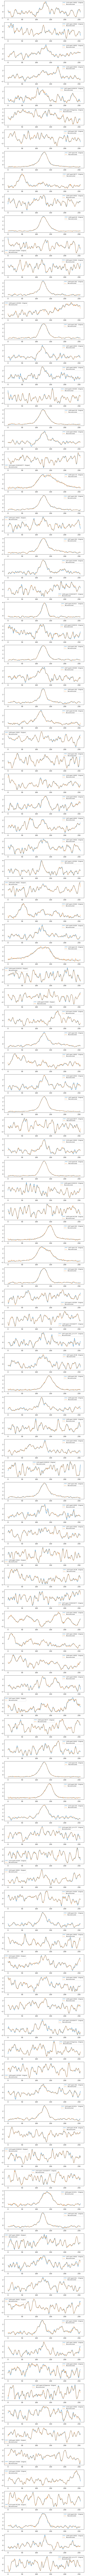

In [64]:
import matplotlib.pyplot as plt

# ============================================
# ✅ 可视化所有样本的原始谱线与重建谱线
# ============================================
import matplotlib.pyplot as plt

model.eval()
all_original = []
all_reconstructed = []
all_names = []

with torch.no_grad():
    for x_batch, names in dataloader:
        x_batch = x_batch.to(DEVICE)
        x_input = x_batch.clone()  # 防止 inplace 修改
        recon, _, _, _ = model(x_input)

        all_original.append(x_batch.cpu())
        all_reconstructed.append(recon.cpu())
        all_names.extend(names)

# 合并成一个大 tensor
all_original = torch.cat(all_original, dim=0).numpy().squeeze(1)
all_reconstructed = torch.cat(all_reconstructed, dim=0).numpy().squeeze(1)

print(f"✅ 共对比 {len(all_names)} 条谱线")

# ==============================
# 绘制所有谱线（每条独立一行）
# ==============================
n = len(all_names)
plt.figure(figsize=(8, 2 * n))

for i in range(5):
    plt.subplot(n, 1, i + 1)
    plt.plot(all_original[i], label=f"{all_names[i]} - Original", color="C0")
    plt.plot(all_reconstructed[i], label="Reconstructed", color="C1", linestyle="--")
    plt.legend(fontsize=8)
    plt.tight_layout()

plt.show()
